# Binary evolution
In this tutorial, we take a look at how to evolve binaries with ``LEGWORK`` and get the most out of the functions in the ``evol`` module.

In [2]:
%matplotlib inline

Let's import the evolution functions and also some other common stuff.

In [3]:
from legwork import evol, utils

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [4]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

## Calculating merger times

We'll focus primarily on the eccentric function since the circular function is just a special case and works exactly the same way.

### Flexible input

This function requires the eccentricity as well as information about the masses and separation of the binary. This is done flexibly such that:

- you can *either* enter the individual masses, `m_1, m_2`, *or* the `beta` constant from Peters (1964)
- you can *either* enter the semi-major axis `a_i` *or* the orbital frequency `f_orb_i`

In these cases `beta` and `a_i` take precedence.

In [5]:
# pick some values
ecc_i = 0.1
m_1 = 7 * u.Msun
m_2 = 42 * u.Msun
f_orb_i = 1e-3 * u.Hz

# calculate other params
beta = utils.beta(m_1, m_2)
a_i = utils.get_a_from_f_orb(f_orb_i, m_1, m_2)

# compute with individual masses and frequency
t_merge = evol.get_t_merge_ecc(ecc_i=ecc_i, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i)

# compute with beta and semi-major axis
t_merge_alt = evol.get_t_merge_ecc(ecc_i=ecc_i, beta=beta, a_i=a_i)

# check you get the same result
print(t_merge == t_merge_alt)

True


### Approximations
These functions are based directly on the equations from Peters (1964) and these consist of four cases which each use a different equation from Peters:

|               Case               | Peters (1964) <br>Equation |        Eccentricity<br>Range        |
|:--------------------------------:|:--------------------------:|:-----------------------------------:|
|         Exactly Circular         |          Eq. 5.10          |               e = 0.0               |
| Small Eccentricity Approximation |       Eq. after 5.14       |                   e < `small_e_tol` |
|           General Case           |          Eq. 5.14          | `small_e_tol` <= e <= `large_e_tol` |
| Large Eccentricity Approximation |     2nd Eq. after 5.14     | `large_e_tol` < e                   |

The ranges in which the different functions are used are determined by `small_e_tol` and `large_e_tol` which are `0.01` and `0.99` by default. Let's take a look at how changing these can affect our results.

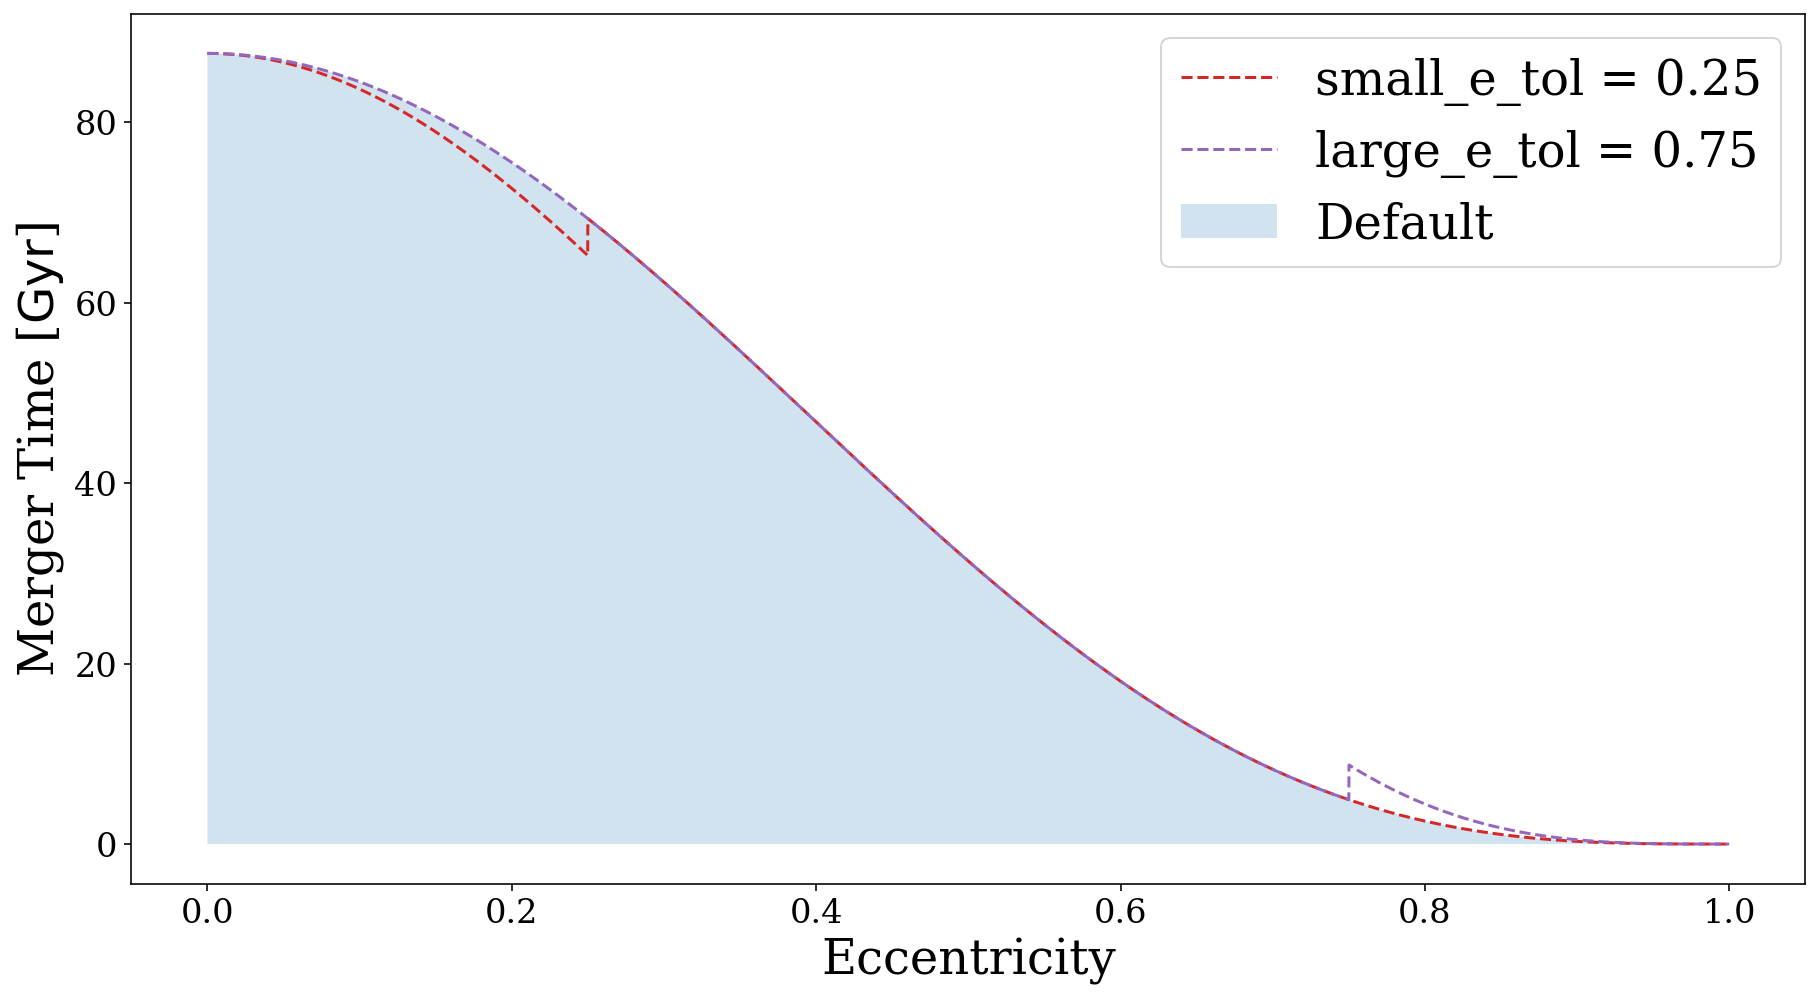

In [6]:
# create random binaries
e_range = np.linspace(0.0, 0.9999, 10000)
m_1 = np.repeat(1, len(e_range)) * u.Msun
m_2 = np.repeat(1, len(e_range)) * u.Msun
f_orb_i = np.repeat(1e-5, len(e_range)) * u.Hz

# calculate merger time using defaults
t_merge = evol.get_t_merge_ecc(ecc_i=e_range, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i)

# calculate two examples with different tolerances
t_merge_small_ex = evol.get_t_merge_ecc(ecc_i=e_range, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i, small_e_tol=0.25)
t_merge_large_ex = evol.get_t_merge_ecc(ecc_i=e_range, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i, large_e_tol=0.75)

# create a figure
fig, ax = plt.subplots(figsize=(15, 8))

# plot the default as an area
ax.fill_between(e_range, 0, t_merge, label="Default", alpha=0.2)

# plot the examples with dashed lines
ax.plot(e_range, t_merge_small_ex, label=r"small_e_tol = 0.25", color="tab:red", linestyle="--")
ax.plot(e_range, t_merge_large_ex, label=r"large_e_tol = 0.75", color="tab:purple", linestyle="--")

ax.set_xlabel("Eccentricity")
ax.set_ylabel("Merger Time [{0:latex}]".format(t_merge.unit))

ax.legend()

plt.show()

Here we can see how adjusting the tolerances can result in drastic changes to the merger times. We leave it to you to determine your balance of runtime and accuracy!

## Evolving binaries

### Flexible output

The same principles as [above](#Flexible-input) (with the flexible input options of the masses and separation) apply. In addition, we make the *output* flexible here too. When evolving a binary, the final evolution that is returned can contain any 
of:

- ``a_evol`` = **"a"**: semi-major axis evolution
- ``f_orb_evol`` = **"f_orb"**: orbital frequency evolution
- ``f_GW_evol`` = **"f_GW"**: gravitational wave frequency evolution
- ``timesteps`` = **"timesteps"**: timesteps corresponding to values in evolutions
- ``ecc_evol`` = **"ecc"**: eccentricity evolution (``evol_ecc()`` only)

You can choose which variables you want to be outputted and their order by including the strings listed above (after the equals signs) in ``output_vars``. Let's try this in practice.

In [7]:
m_1 = 7 * u.Msun
m_2 = 42 * u.Msun
f_orb_i = 1e-3 * u.Hz

# we could just ask for a_evol
a_evol = evol.evol_circ(m_1=m_1, m_2=m_2, f_orb_i=f_orb_i, output_vars="a")

# or timesteps as well
a_evol, timesteps = evol.evol_circ(m_1=m_1, m_2=m_2, f_orb_i=f_orb_i, output_vars=["a", "timesteps"])

### Timesteps

``LEGWORK`` also allows you to determine the number and spacing of the timesteps to report about the evolution.

There are three relevant parameters for this:

- `t_evol`: the amount of time to evolve each binary for (this will default to the merger time)
- `n_step`: the number of **linearly spaced** steps to take between 0 and `t_evol`
- `timesteps`: an exact custom array of timesteps to use in place of the above parameters

Lets try evolving a binary until its merger and adjusting the number of timesteps

In [8]:
m_1 = 7 * u.Msun
m_2 = 42 * u.Msun
f_orb_i = 1e-3 * u.Hz

# work out the merger time
t_merge = evol.get_t_merge_circ(m_1=m_1, m_2=m_2, f_orb_i=f_orb_i).to(u.yr)

# evolve with only 10 timesteps
f_orb_evol_coarse, t_coarse = evol.evol_circ(t_evol=t_merge, n_step=10, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i,
                                             output_vars=["f_orb", "timesteps"])

# same thing but with 10000!
f_orb_evol_fine, t_fine = evol.evol_circ(t_evol=t_merge, n_step=10000, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i,
                                         output_vars=["f_orb", "timesteps"])

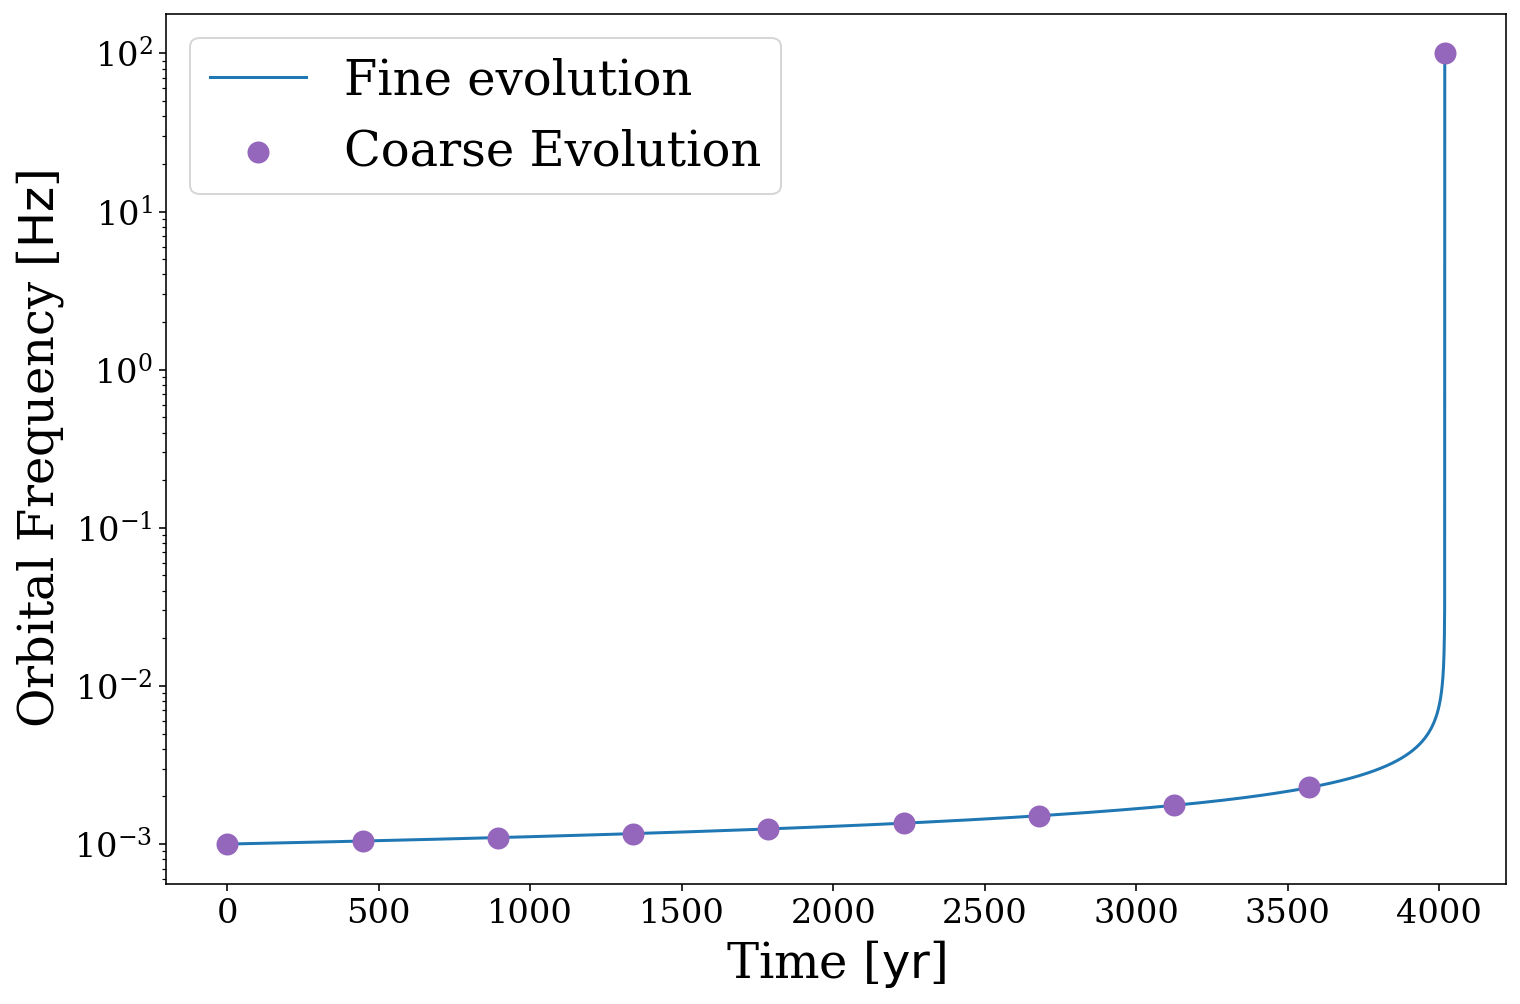

In [9]:
fig, ax = plt.subplots()

ax.plot(t_fine, f_orb_evol_fine, label="Fine evolution")
ax.scatter(t_coarse, f_orb_evol_coarse, color="tab:purple", zorder=3, s=100, label="Coarse Evolution")

ax.set_xlabel("Time [{:latex}]".format(t_fine.unit))
ax.set_ylabel("Orbital Frequency [{:latex}]".format(f_orb_evol_fine.unit))

ax.set_yscale("log")

ax.legend()

plt.show()

We can see here that we capture most of the evolution well with few timesteps...until the binary approaches its merger. Let's try still taking few timesteps but spacing them such that there are more at the end.

In [10]:
m_1 = 7 * u.Msun
m_2 = 42 * u.Msun
f_orb_i = 1e-3 * u.Hz

# work out the merger time
t_merge = evol.get_t_merge_circ(m_1=m_1, m_2=m_2, f_orb_i=f_orb_i).to(u.yr).value

# do a sort of lookback time thing
t_coarse = (t_merge - np.logspace(0, np.log10(t_merge), 10))[::-1] * u.yr
t_coarse[-1] = t_merge * u.yr
f_orb_evol_coarse, t_coarse = evol.evol_circ(timesteps=t_coarse, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i,
                                             output_vars=["f_orb", "timesteps"])

# evolve until merger with a bunch of timesteps
f_orb_evol_fine, t_fine = evol.evol_circ(t_evol=t_merge * u.yr, n_step=10000, m_1=m_1, m_2=m_2,
                                         f_orb_i=f_orb_i, output_vars=["f_orb", "timesteps"])

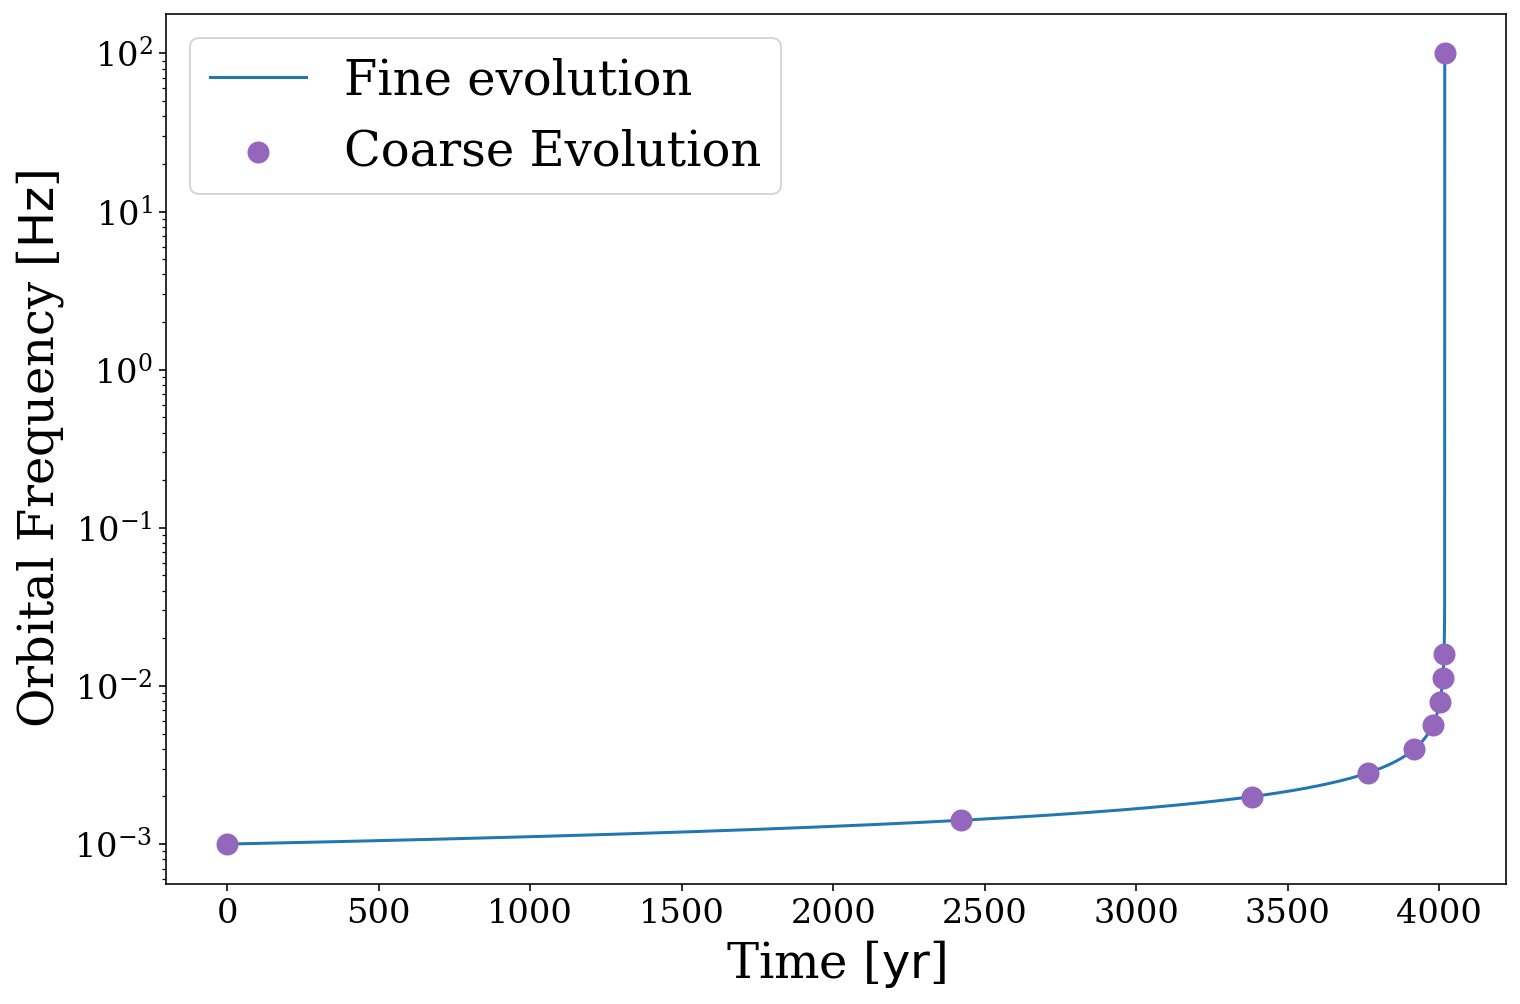

In [11]:
fig, ax = plt.subplots()

ax.plot(t_fine, f_orb_evol_fine, label="Fine evolution")
ax.scatter(t_coarse, f_orb_evol_coarse, color="tab:purple", zorder=3, s=100, label="Coarse Evolution")

ax.set_xlabel("Time [{:latex}]".format(t_fine.unit))
ax.set_ylabel("Orbital Frequency [{:latex}]".format(f_orb_evol_fine.unit))

ax.set_yscale("log")

ax.legend()

plt.show()

And now we can use the same number of timesteps yet resolve the full evolution quite nicely, neat!

## Examples uses
Hopefully by this point you're comfortable with the use of the ``evol`` module and want to take it for a spin! Let's do just that.

As an example, let's evolve a series of random binaries for a fixed period of time and see how their eccentricities and frequencies change.

In [35]:
# create some random binaries with the same masses
n_binaries = 2500
m_1 = np.repeat(15, n_binaries) * u.Msun
m_2 = np.repeat(15, n_binaries) * m_1
f_orb_i = 10**(np.random.uniform(-6, -3, n_binaries)) * u.Hz
ecc_i = np.random.uniform(0, 0.9, n_binaries)

# set up timesteps
timesteps = (np.logspace(-2, 7, 1000) * u.yr).to(u.Myr)

# check which binaries will merge during that time
t_merge = evol.get_t_merge_ecc(ecc_i=ecc_i, m_1=m_1, m_2=m_2, f_orb_i=f_orb_i)
merged = t_merge <= timesteps[-1]
inspiral = np.logical_not(merged)

# evolve the binaries that won't merge
ecc_evol, f_orb_evol = evol.evol_ecc(ecc_i=ecc_i[inspiral], m_1=m_1[inspiral], m_2=m_2[inspiral],
                                     f_orb_i=f_orb_i[inspiral], timesteps=timesteps, t_before=10 * u.yr)

print("Completed evolution of {} binaries".format(n_binaries), end="")
print(r" for {:1.0f} {}".format(timesteps[-1].value, timesteps.unit))

Completed evolution of 2500 binaries for 10 Myr


59.7% of binaries merged


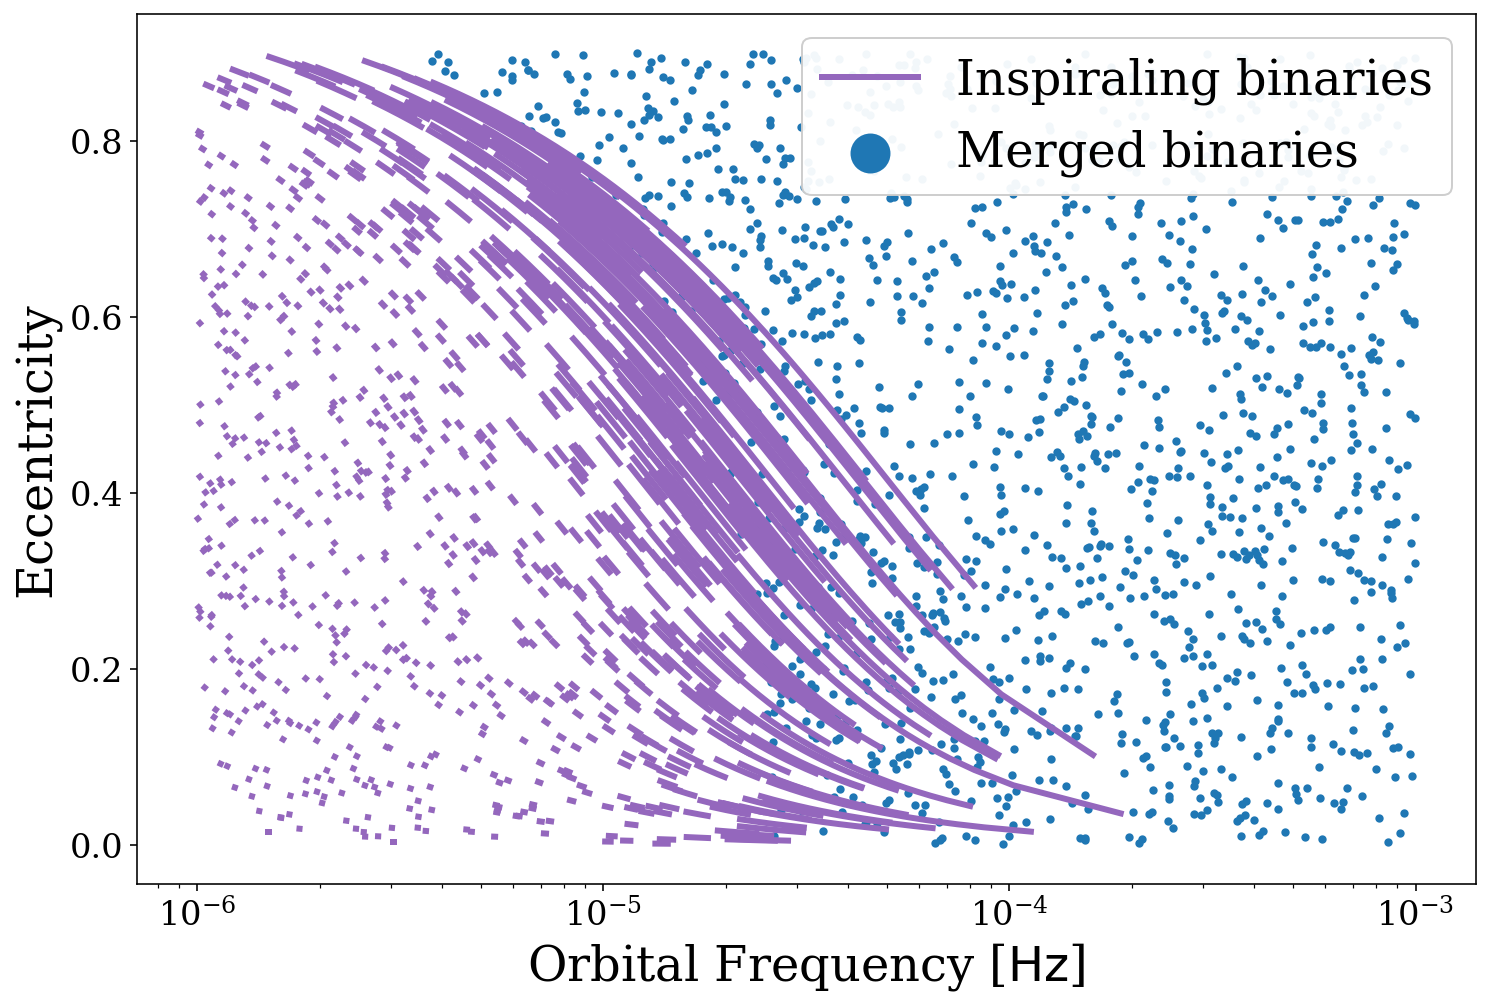

In [36]:
# create a plot
fig, ax = plt.subplots()

# check which binaries merged
print("{:1.1f}% of binaries merged".format(len(ecc_i[merged]) / n_binaries * 100))

# plot the merged binaries as scatter points
ax.scatter(f_orb_i[merged], ecc_i[merged], label="Merged binaries", s=10)

# plot the inspiraling line by connecting lines from their start to their end
for i in range(len(ecc_evol)):
    label = "Inspiraling binaries" if i == 0 else ""
    mask = f_orb_evol[i] != 1e2 * u.Hz
    ax.plot(f_orb_evol[i][mask], ecc_evol[i][mask], color="tab:purple", lw=3, label=label)

ax.legend(loc="upper right", framealpha=0.95, markerscale=6)
    
ax.set_xscale("log")

ax.set_xlabel("Orbital Frequency [{:latex}]".format(f_orb_evol.unit))
ax.set_ylabel("Eccentricity")

plt.show()

We can see here that either higher eccentricity or high frequency can speed up a merger. We also get a sense of how the parameters evolve. Fun!

That concludes this tutorial on binary evolution using the ``LEGWORK`` package. Be sure to check out [the other tutorials](../tutorials.rst) to learn more about how ``LEGWORK`` can do the legwork for you!